# What is a P-Value?

A p-value is a measure of the evidence against a null hypothesis. The p-value answers the question 'if the null hypothesis is true and we repeated many times, how often would see this value". The p-value gives the probability of seeing the test value if the null hypothesis is true.


## How is a p-value calculated:

1. Calculate the conversion rates for the control and exposed groups (successes / total)
2. Calculate the average conversion rate (pooled probability)
    - The pooled proportion is used under the assumption that the null hypothesis is true, which means there is no significant difference between the two population proportions (p1 and p2). The purpose of pooling the proportions is to obtain a single, overall estimate of the true proportion based on the combined information from both samples.
3. Use these values to calculate the z-score (difference in conversion rates between control and exposed groups in standard deviation units)
4. Obtain the p-value (probability of seeing the test value or less) using the normal distribution's cumulative density function
    - The reason we can use the cumulative density function (CDF) of the normal distribution to obtain the p-value for a test of binomial proportions is due to the Central Limit Theorem (CLT). The CLT states that the sum or average of a large number of independent and identically distributed random variables, each with finite mean and variance, will approach a normal distribution as the number of variables goes to infinity.
    - For a two-tailed test, the p-value is given by:
        - p-value = 2 * (1 - CDF(Z)) where Z is the calculated Z-score and CDF(Z) is the cumulative probability of the standard normal distribution up to Z.
    - For a one-tailed test, the p-value is given by:
        - p-value = 1 - CDF(Z) (for an upper-tailed test) or p-value = CDF(Z) (for a lower-tailed test)

## How can we know that the p-value we're calculating is correct?

To verify that the calculations are correct we should be able to show that when the null hypothesis is true (conversion rates are the same for both groups), 5% of p-values are less than 0.05. 

## Show how "peeking" (also known as multiple testing) breaks this assumption

## Show how the sample size affects statistical power


In [64]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binom, binomtest, norm

# Set the Seaborn style
sns.set(style="dark")
pd.set_option("display.float_format", lambda x: "%.5f" % x)

## Set up some shared functions

In [65]:
def run_experiment(p1, p2, n1, n2):
    control_conversions = binom.rvs(n1, p1)
    exposed_conversions = binom.rvs(n2, p2,)
    control_conversion_rate = control_conversions / n1
    exposed_conversion_rate = exposed_conversions / n2
    return control_conversion_rate, exposed_conversion_rate


def get_z_score(
    control_conversion_rate, exposed_conversion_rate, control_sample, exposed_sample
):
    p1 = control_conversion_rate
    p2 = exposed_conversion_rate
    n1 = control_sample
    n2 = exposed_sample

    pooled_prop = (p1 * n1 + p2 * n2) / (n1 + n2)
    z = (p2 - p1) / math.sqrt(pooled_prop * (1 - pooled_prop) * (1 / n1 + 1 / n2))

    return z

def get_p_value(z_score, test_sides):
    if test_sides == 1:
        # for an upper tailed test the sign of the z-score matters since only positive values will allows us to reject the null hypothesis
        return 1 - norm.cdf(z_score)
    else:
        # for a two tailed test we need to take the absolute value of the z-score since we are interested in the magnitude of the z-score, not the direction
        return 2 * (1 - norm.cdf(abs(z_score)))
    

## Run a single experiment

In [77]:
p1 = 0.1
p2 = 0.12
n1 = 1000
n2 = 1000
(control_conversion_rate, exposed_conversion_rate) = run_experiment(p1, p2, n1, n2)
print('control conversion rate: ', control_conversion_rate)
print('exposed conversion rate: ', exposed_conversion_rate)

z_score = get_z_score(control_conversion_rate, exposed_conversion_rate, n1, n2)
print('z-score: ', z_score)

control conversion rate:  0.099
exposed conversion rate:  0.11
z-score:  0.8040568330379041


## Calculate p-value for a one or two-tailed test

In [78]:
# When running a two-tailed test, the p-value is multiplied by 2 to account for 
# the fact that there are two areas (or tails) of the distribution where the effect
#  of interest could occur. This is done to maintain the correct Type I error rate (alpha level) for the test
p_value = get_p_value(z_score, 1)
print('p-value: ', p_value)

p-value:  0.21068207656087123


## Simulated experiments where the null hypothesis is true

In [46]:
# Simulate running 10,000 experiments where the null hypothesis is true, i.e.
# the conversion rate is the same for both the control and exposed groups.
# We expect the p-value to be less than 0.05 in 5% of the experiments.

def get_simulated_p_values(p1, p2, n1, n2, num_experiments):
    p_values = []
    for _ in range(num_experiments):
        control_conversions = binom.rvs(n1, p1)
        exposed_conversions = binom.rvs(n2, p2,)
        control_conversion_rate = control_conversions / n1
        exposed_conversion_rate = exposed_conversions / n2
        
        z_score = get_z_score(control_conversion_rate, exposed_conversion_rate, n1, n2)
        p_value = get_p_value(z_score, test_sides=2)
        p_values.append(p_value)

    return p_values

# Set parameters
n1 = 10000
n2 = 10000
p = 0.5
num_experiments = 10000

# Run multiple experiments
p_values = get_simulated_p_values(p, p, n1, n2, num_experiments)

# Calculate the proportion of p-values less than 0.05
false_positive_rate = sum(pv < 0.05 for pv in p_values) / num_experiments

print("Proportion of p-values less than 0.05:", false_positive_rate)

Proportion of p-values less than 0.05: 0.0461


## Show that the distribution of p-values is constant

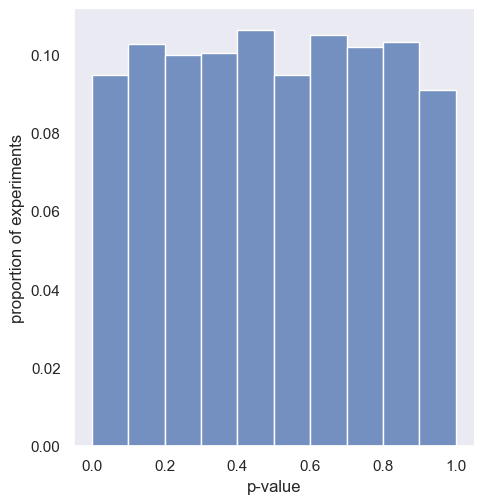

In [47]:
""" 
The p-value is a measure of the probability of observing a test statistic as extreme or more extreme than the 
one calculated from the sample data, assuming the null hypothesis is true. When the null hypothesis is true, 
the p-values follow a uniform distribution between 0 and 1. This means that each p-value within this range 
has an equal probability of occurring.

This uniform distribution of p-values occurs because the null hypothesis assumes there is no systematic 
difference between the groups. In this case, the test statistics are just as likely to be positive as they
are to be negative, and they are just as likely to be small as they are to be large. As a result, the 
probability of observing a particular p-value is the same across the entire range of possible p-values, 
resulting in a uniform distribution.
 """

def plot_p_values(p_values):
    sns.displot(p_values, kde=False, bins=10, stat="probability")
    plt.xlabel("p-value")
    plt.ylabel("proportion of experiments")
    plt.show()

plot_p_values(p_values)


## The Problem with Peeking

In [80]:

def demonstrate_peeking_problem(
    p1,
    p2,
    num_experiments,
    total_sample,
    peeks_count,
):
    '''
     Simulates runnning the same experiment many times and peeking at the results to obtain a p-value at various stages 
     of each experiment. The function aims to demonstrate how the proability of obtaining a false positive result increases
    when the p-value is calculated multiple times during an experiment. 
    '''

    #  array holding a row for each experiment where the columns represent the p-values calculated at each peek
    p_values = np.empty(peeks_count).reshape(1, peeks_count)
    for _ in range(num_experiments):
        # array holding the accumulated sample data obtained for the control group
        control_conversions = np.empty(0)
        # array holding the accumulated sample data obtained for the exposed group
        exposed_conversions = np.empty(0)
        # array holding the p-values calculated at each peek
        daily_p_values = np.empty(0)

        for _ in range(peeks_count):
            control_daily_conversions = binom.rvs(
                n=1, p=p1, size=total_sample // peeks_count
            )
            exposed_daily_conversions = binom.rvs(
                n=1, p=p2, size=total_sample // peeks_count
            )
            control_conversions = np.append(
                control_conversions, control_daily_conversions
            )
            exposed_conversions = np.append(
                exposed_conversions, exposed_daily_conversions
            )
            control_conversion_rate = control_conversions.mean()
            exposed_conversion_rate = exposed_conversions.mean()

            z = get_z_score(
                control_conversion_rate,
                exposed_conversion_rate,
                len(control_conversions),
                len(exposed_conversions),
            )

            pv = get_p_value(z, 2)
            daily_p_values = np.append(daily_p_values, pv)

        p_values = np.vstack((p_values, daily_p_values))

    p_values_frame = pd.DataFrame(p_values)

    return p_values_frame


total_sample = 1000
peeks_count = 20
conversion_rate_a = 0.5
conversion_rate_b = 0.5
alpha = 0.05
num_experiments = 1000

p_values_frame = demonstrate_peeking_problem(
    conversion_rate_a,
    conversion_rate_b,
    num_experiments,
    total_sample,
    peeks_count,
)

# convert the p-values to booleans where True indicates a significant result according to the alpha value
significant_frame = p_values_frame.applymap(lambda x: x < alpha)

daily_frame= significant_frame.copy()
# add a row to the dataframe that contains the proportion of false positive results for each peek across all experiments
daily_frame.loc["percent_false_positive"] = daily_frame.mean(axis=0)

cumulative_frame = significant_frame.copy()
cumulative_sum = cumulative_frame.cumsum(axis=1)
# replace any values greater than 1 with 1
cumulative_sum = cumulative_sum.clip(
    0, 1
)  
# update the dataframe with the updated values
cumulative_frame[cumulative_sum == 1] = True
# add a row to the dataframe that contains the cumulative proportion of false positive results for each peek across all experiments
cumulative_frame.loc["percent_false_positive"] = cumulative_frame.mean(axis=0)


## Draw the simulation results

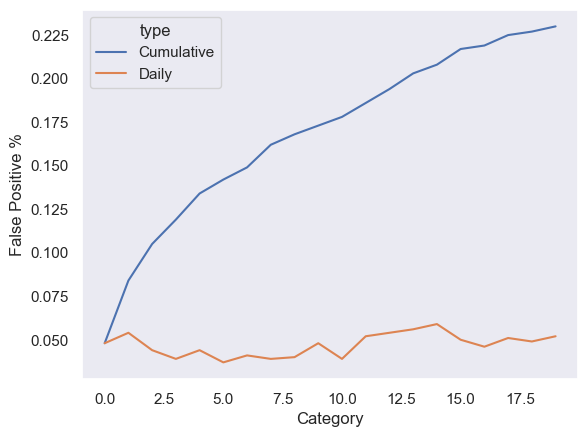

In [81]:
# Assuming you have two dataframes named total_frame and daily_frame
cumulative_row = cumulative_frame.loc[["percent_false_positive"]]
cumulative_row["type"] = "Cumulative"

daily_row = daily_frame.loc[["percent_false_positive"]]
daily_row["type"] = "Daily"

# Concatenate the two rows into a single dataframe
combined_rows = pd.concat([cumulative_row, daily_row])
# print("1", combined_rows)

# Reset the index to create a column from the current index
combined_rows.reset_index(inplace=True)
# print("2", combined_rows)

# Rename the columns to make them more descriptive
combined_rows.rename(columns={"index": "Peek #", "percent_false_positive": "False Positive %"}, inplace=True)
# print("3", combined_rows)

# Melt the dataframe to get it in the right format for seaborn
melted_rows = combined_rows.melt(id_vars=["Peek #", "type"], var_name="Category", value_name="False Positive %")
# print("4", melted_rows)

# Plot the data using seaborn's lineplot
sns.lineplot(data=melted_rows, x="Category", y="False Positive %", hue="type")
plt.show()

## Statistical Power

### Or
![Ioannidis](img/ioannidis.png)

### Underpowered experiments are bad
![Type S Error](img/type-s-error.png)

In [54]:
def simulate_power(
    p1,
    p2,
    num_experiments,
    total_sample,
    division_count,
):
    p_values = np.empty(division_count).reshape(1, division_count)
    for _ in range(num_experiments):
        control_conversions = np.empty(0)
        exposed_conversions = np.empty(0)
        daily_p_values = np.empty(0)

        for _ in range(division_count):
            control_daily_conversions = binom.rvs(
                n=1, p=p1, size=total_sample // division_count
            )
            exposed_daily_conversions = binom.rvs(
                n=1, p=p2, size=total_sample // division_count
            )
            control_conversions = np.append(
                control_conversions, control_daily_conversions
            )
            exposed_conversions = np.append(
                exposed_conversions, exposed_daily_conversions
            )
            control_conversion_rate = control_conversions.mean()
            exposed_conversion_rate = exposed_conversions.mean()

            z = get_z_score(
                control_conversion_rate,
                exposed_conversion_rate,
                len(control_conversions),
                len(exposed_conversions),
            )

            pv = get_p_value(z, 2)
            daily_p_values = np.append(daily_p_values, pv)

        p_values = np.vstack((p_values, daily_p_values))

    p_values_frame = pd.DataFrame(p_values)

    return p_values_frame


total_sample = 2000
division_count = 20
conversion_rate_a = 0.45
conversion_rate_b = 0.5
min_detectable_effect = conversion_rate_b - conversion_rate_a
alpha = 0.05
test_sides = 2
num_experiments = 1000

p_values_frame = simulate_power(
    conversion_rate_a,
    conversion_rate_b,
    num_experiments,
    total_sample,
    division_count,
)

step = total_sample // division_count

significant_frame = p_values_frame.applymap(lambda x: x < alpha)

daily_frame = significant_frame.copy()
new_col_headers = np.arange(step, total_sample + step, step)
daily_frame = daily_frame.set_axis(new_col_headers, axis=1)
daily_frame.loc["percent_true_positive"] = daily_frame.mean(axis=0)
print(daily_frame.loc["percent_true_positive"])

100    0.11588
200    0.17582
300    0.23377
400    0.30769
500    0.36464
600    0.44356
700    0.48252
800    0.50649
900    0.58442
1000   0.62338
1100   0.66933
1200   0.70629
1300   0.74426
1400   0.76723
1500   0.79221
1600   0.81818
1700   0.84815
1800   0.87313
1900   0.87912
2000   0.89510
Name: percent_true_positive, dtype: object


### Plot the result

Text(0, 0.5, 'True Positive %')

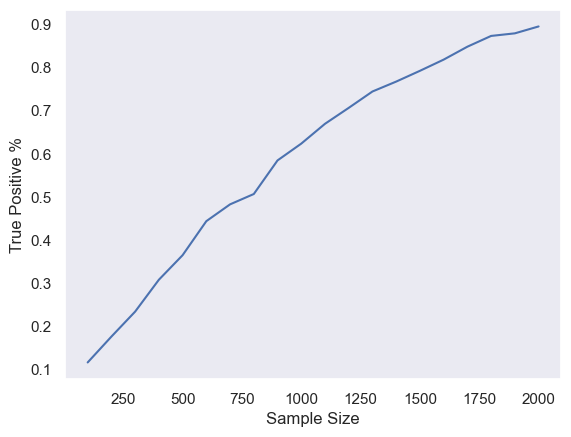

In [60]:
plt = sns.lineplot(data=daily_frame.loc["percent_true_positive"])
plt.set_xlabel("Sample Size")
plt.set_ylabel("True Positive %")

### Does our simulation match what we would expect if we calculated the required sample size beforehand?

### Formula to determine sample size required to reach a given power level

![sample size formula](img/sample-size-formula.png)

In [61]:
# This is the function we are using in Appcues experiments to determine the necessary sample size
def calculate_sample_size(
    baseline, min_detectable_effect, test_sides, significance_level, power_level
):
    p1 = baseline
    p2 = baseline + min_detectable_effect
    p_bar = (p1 + p2) / 2
    q_bar = 1 - p_bar
    q1 = 1 - p1
    q2 = 1 - p2
    delta = abs(p2 - p1)

    numerator_part_1 = math.sqrt(p_bar * q_bar * 2) * norm.ppf(
        1 - significance_level / test_sides
    )
    numerator_part_2 = math.sqrt(p1 * q1 + p2 * q2) * norm.ppf(power_level)
    numerator = (numerator_part_1 + numerator_part_2) ** 2
    denominator = delta**2

    return round(numerator / denominator)


print(
    calculate_sample_size(
        conversion_rate_a, min_detectable_effect, test_sides, alpha, power_level=0.8
    )
)

1565


### Formula to determine power level obtained by a give sample size and significance level

![power formula](img/power-formula.png)

In [63]:
def calculate_power(
    sample_size, baseline, min_detectable_effect, test_sides, significance_level
):
    p1 = baseline
    p2 = baseline + min_detectable_effect
    p_bar = (p1 + p2) / 2
    q_bar = 1 - p_bar
    q1 = 1 - p1
    q2 = 1 - p2
    delta = abs(p2 - p1)
    z_score_for_sig_level = norm.ppf(1 - significance_level / test_sides)

    part_1 = delta / math.sqrt(p1 * q1 / sample_size + p2 * q2 / sample_size)
    part_2a = math.sqrt(p_bar * q_bar * (2 / sample_size))
    part_2b = math.sqrt(p1 * q1 / sample_size + p2 * q2 / sample_size)
    part_2 = z_score_for_sig_level * part_2a / part_2b

    return norm.cdf(part_1 - part_2)


power = calculate_power(
    1565, conversion_rate_a, min_detectable_effect, test_sides, alpha
)
print(power)

0.8000822542348274
